In [1]:
import math
import importlib

import pickle
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client, get_full_strategy
from src.toy_functions import Hartmann6D
import pickle

silence_ax_client()


-0.0 -0.9874311636230129


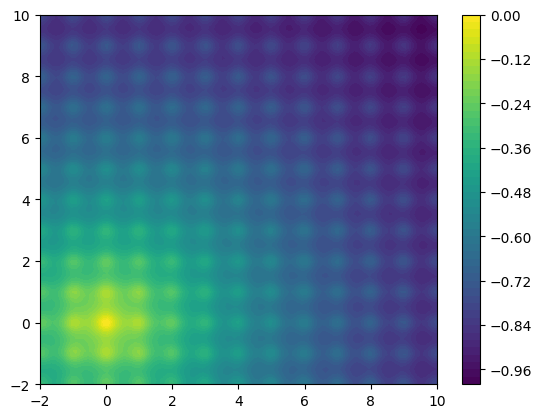

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  32.331797  20.185068
2         2_0   3.198790   2.036187
3         3_0   1.273582  80.715805
4         4_0  12.614530   8.146863
5         5_0  18.439090  41.234362
6         6_0   1.897448   4.089940
7         7_0   7.271545  17.112034
8         8_0  74.742710   1.694442
9         9_0  90.527783  70.219124
10       10_0   9.294626   7.083437
11       11_0   2.653157  31.209185
12       12_0  27.209757   3.150032
13       13_0  15.766731  11.054976
14       14_0   1.563401   1.096509
15       15_0   4.615645  47.451327
16       16_0  45.819393   4.698624
17       17_0  49.561115  55.222621
18       18_0   4.992576   5.468270
19       19_0   1.450887  12.836611
20       20_0  14.632061   1.273255
21       21_0  29.299703  26.998916
22       22_0   2.856945   2.725023
23       23_0   8.587015  60.609718
24       24_0  83.635885   6.113955
25       25_0  60.117162  14.769913
26       26_0   5.848666   1

<Axes: xlabel='x0', ylabel='x1'>

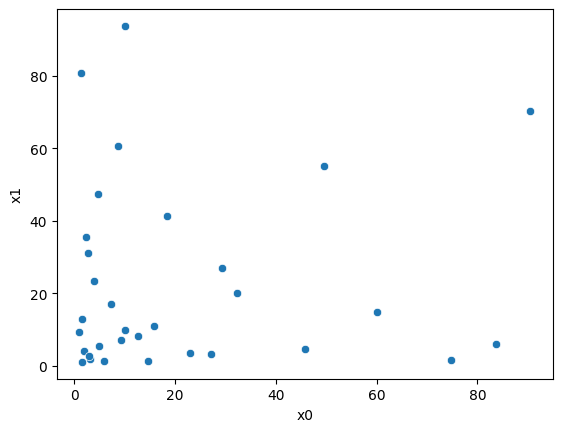

In [3]:
client = Client()


client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling="log",
        )
        for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

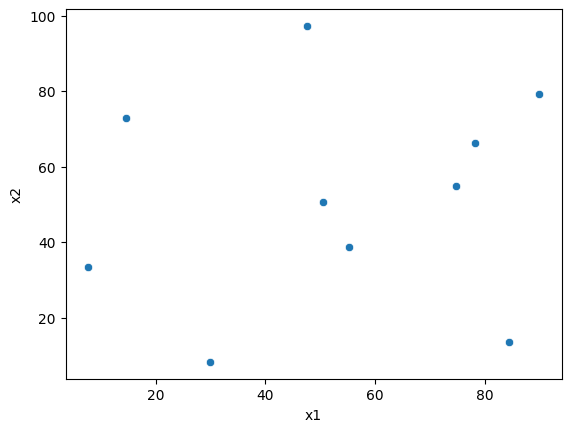

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

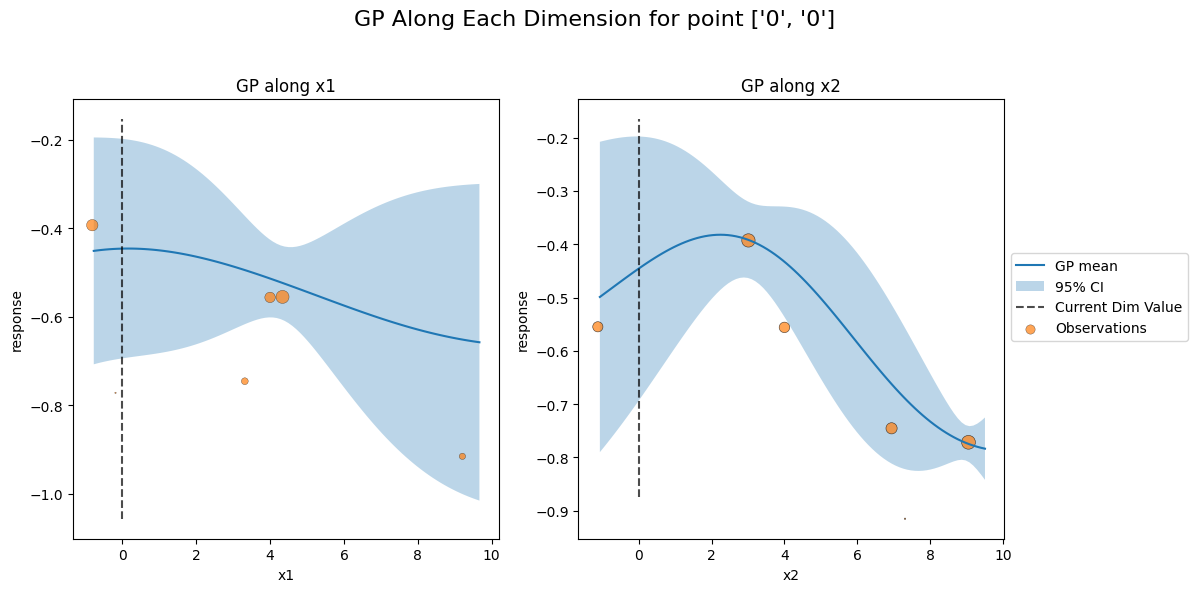

In [5]:

from src import ax_helper
importlib.reload(GPVisualiser)

client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)


batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client)
plotter = GPVisualiser.GPVisualiserMatplotlib.init_from_client(client)
plotter.plot_all([0,0])

In [6]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,3.316336,6.938245,-0.745377
2,2_0,4.336982,-1.119265,-0.554910
3,3_0,9.207146,7.307202,-0.915056
4,4_0,-0.813497,3.011777,-0.392917
5,5_0,-0.184327,9.048521,-0.771621


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

In [8]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [9]:

pickle.dump(batch_handler.client, open("data/ax_clients/ackley_client.pkl", "wb"))

In [10]:
pickle.load(open("data/ax_clients/ackley_client.pkl", "rb"))

In [11]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,3.316336,6.938245,-0.745377
2,2_0,4.336982,-1.119265,-0.554910
3,3_0,9.207146,7.307202,-0.915056
4,4_0,-0.813497,3.011777,-0.392917
5,5_0,-0.184327,9.048521,-0.771621


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [12]:
range_parameters = [
    RangeParameterConfig(name="x1", parameter_type="float", bounds=(-2, 10))
]

metric_name = "response"
dim_names = ["x1"]


def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x, y: y + np.random.normal(0, 1)


def plot_test(fig=None):
    if fig:
        import plotly.graph_objects as go


        fig.add_trace(go.Scatter(
            x=np.linspace(-2, 10, 100),
            y=[test_function(x) for x in np.linspace(-2, 10, 100)],
            mode="lines",
            name="True function",
            line=dict(color="black")
        ))
        fig.show()
    else:
        plt.plot(
            np.linspace(-2, 10, 100),
            [test_function(x) for x in np.linspace(-2, 10, 100)],
            color="black",
            label="True function",
        )



In [13]:
from src import ax_helper
importlib.reload(ax_helper)

<module 'src.ax_helper' from 'c:\\GitHub\\BO-Coli\\src\\ax_helper.py'>

In [14]:
tester = ax_helper.SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)


c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



In [15]:
fig = runs.plot_GP(SingleTaskGP)
plot_test(fig)

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

In [16]:
from src import model_generation as mg
importlib.reload(mg)


runs = tester.run(
    mg.GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(mg.GammaNoiseSGP)


plot_test(runs)

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

In [17]:
runs = tester.run(mg.GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(mg.GammaNoiseSGP, figsize=(8, 4))
plot_test(runs)

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Heteroscedastic noise

In [18]:
def noise_fn_low(x, y= None):
    return y + np.random.normal(0, 1)*(x['x1']+2)/12


runs = tester.run(mg.GammaNoiseSGP, n_runs=4, technical_repeats=3, batch_size=3, noise_fn=noise_fn_low, plot_each=False)
fig =runs.plot_GP(mg.GammaNoiseSGP, figsize=(12, 6))
plot_test(fig)

* The white noise kernel is unable to accommodate linear heteroscedastic noise.

## Technical repeat adaptive kernel

In [19]:
importlib.reload(mg)
fig = runs.plot_GP(mg.HeteroNoiseSGP, figsize=(12, 6))
plot_test(fig)

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



* Fitting a gp to pre-investigated data appear perform quite badly 

## Heteroscedastic + fixed white noise

In [20]:


fig = runs.plot_GP(mg.HeteroWhiteSGP, figsize=(12, 6))
plot_test(fig)

Much better performance when data is acquired during the run.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [21]:


save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,


In [22]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

NameError: name 'SequentialRuns' is not defined

## Sequential runs no noise

In [ ]:
def noise_fn(x, y):
    return y

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=40, technical_repeats=2, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP)

* Save the data for our testing purposes

In [ ]:
client_dir = r"data/ax_clients/"
runs.client.save_to_json_file(client_dir + "hartmann6_runs.json")

In [ ]:
client._experiment.parameters.keys()

dict_keys(['x1', 'x2'])

In [ ]:
dir(client._experiment)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arms_by_name',
 '_arms_by_signature',
 '_attach_trial',
 '_cache_metric_fetch_error',
 '_check_TTL_on_running_trials',
 '_data_by_trial',
 '_db_id',
 '_default_data_type',
 '_eq_skip_db_id_check',
 '_experiment_type',
 '_fetch_trial_data',
 '_get_last_data_without_similar_rows',
 '_initial_auxiliary_experiments_by_purpose',
 '_is_test',
 '_lookup_or_fetch_trials_results',
 '_metric_fetching_errors',
 '_metrics_by_class',
 '_name',
 '_name_and_store_arm_if_not_exists',
 '_optimization_config',
 '_properties',
 '_register_

In [ ]:
client._experiment.metrics

{'response': MapMetric('response')}

In [ ]:
client = Client().load_from_json_file(client_dir + "hartmann6_runs.json")
ax_helper.get_obs_from_client(client)

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
1,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
2,2_0,0.091530,0.880376,0.928537,0.704015,0.876092,0.518249,0.023908
3,2_0,0.091530,0.880376,0.928537,0.704015,0.876092,0.518249,0.023908
4,4_0,0.622244,0.318554,0.136330,0.214354,0.206763,0.373729,0.656424
...,...,...,...,...,...,...,...,...
76,76_0,0.483800,1.000000,0.870542,1.000000,1.000000,0.007490,0.383747
77,76_0,0.483800,1.000000,0.870542,1.000000,1.000000,0.007490,0.383747
78,78_0,1.000000,1.000000,1.000000,1.000000,1.000000,0.488797,0.000062
79,78_0,1.000000,1.000000,1.000000,1.000000,1.000000,0.488797,0.000062


## Noise vs technical repeats for sequential Single task GP
* SingleTaskGP
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
import src.stats_eval_helper as seh

In [ ]:
explo_dict:dict = pickle.load(open(save_dir + r"singleGP_noise_vs_t_repeats.pkl", "rb"))

def get_top_deciles(explo_dict):
    return {id:ax_helper.get_above_percentile(df, 3.4, .9) for id, df in explo_dict.items()}

get_top_deciles(explo_dict)
hits = seh.hit_stats(get_top_deciles(explo_dict))
hits

TP_index  \
tech_repeats noise                                                      
1            0.0    [34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 47, 4...   
             0.2    [39, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...   
             0.4                                                   []   
             0.6                                                   []   
             0.8                                                   []   
...                                                               ...   
8            1.4                                                   []   
             1.6                                                   []   
             1.8                                                   []   
             2.0                                                   []   
             2.2                                                   []   

                        FP_index  \
tech_repeats noise                 
1            0.0              []   
             0.2        [52, 53]   
             0.4              []   
             0.6            [83]   
             0.8    [55, 92, 95]   
...                          ...   
8            1.4              []   
             1.6              []   
             1.8              []   
             2.0              []   
             2.2              []   

                                                             TN_index  \
tech_repeats noise                                                      
1            0.0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.2    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.4    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.6    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.8    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
...                                                               ...   
8            1.4    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             1.6    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             1.8    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             2.0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             2.2    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                FN_index  TP FP   TN FN Precision    Recall  \
tech_repeats noise                                                            
1            0.0                      []  20  0   81  0       1.0       1.0   
             0.2    [40, 51, 61, 62, 80]  17  2   77  5  0.894737  0.772727   
             0.4                      []   0  0  101  0       0.0       0.0   
             0.6                      []   0  1  100  0       0.0       0.0   
             0.8                      []   0  3   98  0       0.0       0.0   
...                                  ...  .. ..  ... ..       ...       ...   
8            1.4                      []   0  0  101  0       0.0       0.0   
             1.6                      []   0  0   81  0       0.0       0.0   
             1.8                      []   0  0   40  0       0.0       0.0   
             2.0                      []   0  0   87  0       0.0       0.0   
             2.2                      []   0  0  101  0       0.0       0.0   

                   Specificity  Accuracy  
tech_repeats noise                        
1            0.0           1.0       1.0  
             0.2      0.974684  0.930693  
             0.4           1.0       1.0  
             0.6      0.990099  0.990099  
             0.8      0.970297  0.970297  
...                        ...       ...  
8            1.4           1.0       1.0  
             1.6           1.0       1.0  
             1.8           1.0       1.0  
             2.0           1.0       1.0  
             2.2           1.0       1.0  

[96 rows x 12 columns]

<Axes: xlabel='noise', ylabel='Accuracy'>

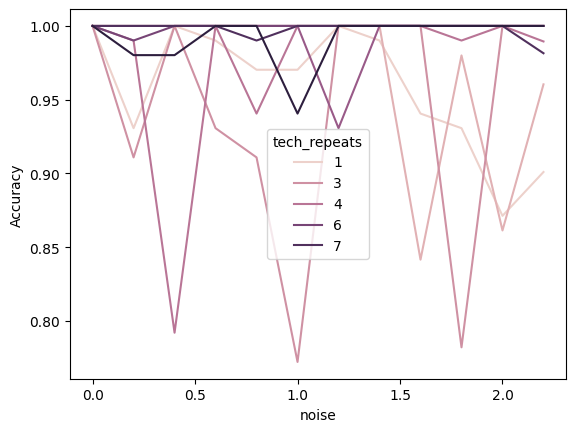

In [ ]:
sns.lineplot(data=hits, x="noise", hue="tech_repeats", y='Accuracy')

## Noise vs technical repeats for sequential Single task GP with Gamma noise
* Gamma noise
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

<Axes: xlabel='noise', ylabel='Accuracy'>

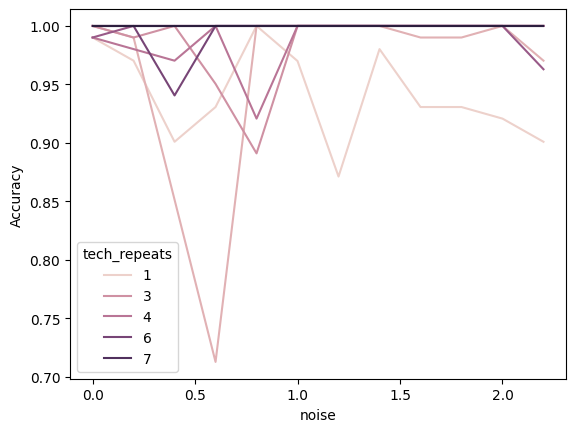

In [ ]:
explo_dict:dict = pickle.load(open(save_dir + r"GammaNoiseSGP_noise_vs_t_repeats.pkl", "rb"))
df = seh.hit_stats(get_top_deciles(explo_dict))
sns.lineplot(data=df, x="noise", hue="tech_repeats", y='Accuracy')